## CSCA5642 Module 3 CNN Cancer Detection Kaggle Mini-Project


## Introduction

This project is to create a CNN deep learning model to correctly identify if metastatic cancer is present in histopathologic scans of lymph node sections. The dataset consists of 220,025 training images (96 by 96 pixels) with known labels, malignant or benign. It is provided by Kaggle, which can be downloaded here [Histopathologic Cancer Detection](https://www.kaggle.com/c/histopathologic-cancer-detection/overview). 
The link to my github repository is [CSCA5642 Module 3](https://github.com/l2chu/CSCA_5642_module3).


## Import Libraries

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import torch
from PIL import Image
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


%matplotlib inline

I want to check if I have a working GPU to use to help train the models.

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("We got a GPU")
    tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("Sorry, no GPU for you...")

We got a GPU


## Import Dataset

In [3]:
train_path = 'train/'
test_path = 'test/'
train_labels_path = 'train_labels.csv'
sample_submission_file = 'sample_submission.csv'


In [4]:
df = pd.read_csv(train_labels_path)
print('Shape of Training DataFrame',df.shape)

df.head()

Shape of Training DataFrame (220025, 2)


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [6]:
# check for duplicate rows
duplicates = df.duplicated().sum()
print("Number of duplicate rows:", duplicates)

Number of duplicate rows: 0


In [7]:
# SHOW THE IMAGE IS 96 BY 96
df['label'] = df['label'].astype(str)  # Convert from int to strings
df['id'] = df['id'].apply(lambda x: f'{x}.tif')
filepath = train_path + df['id'].iloc[0]
width, height = Image.open(filepath).size
print(f'The image size is {width} by {height}.')

The image size is 96 by 96.


In [8]:
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [9]:
# SHOW HOW MANY TEST DATA THERE IS AND MAKE A DF FOR IT
df_sample = pd.read_csv(sample_submission_file)
print('Shape of Test DataFrame', df_sample.shape)
df_sample.head()

Shape of Test DataFrame (57458, 2)


,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


### We can see that the labels are integer type and each image is 96 by 96 pixels. There are a total of 220,025 images in the training dataset and 57,458 images in the test dataset. Also, the label for the sample submission dataset are defaulted to 0.

## EDA 

Let's take a look at the distribution of the label data.

In [10]:
label_counts = df["label"].value_counts()
label_counts

0    130908
1     89117
Name: label, dtype: int64

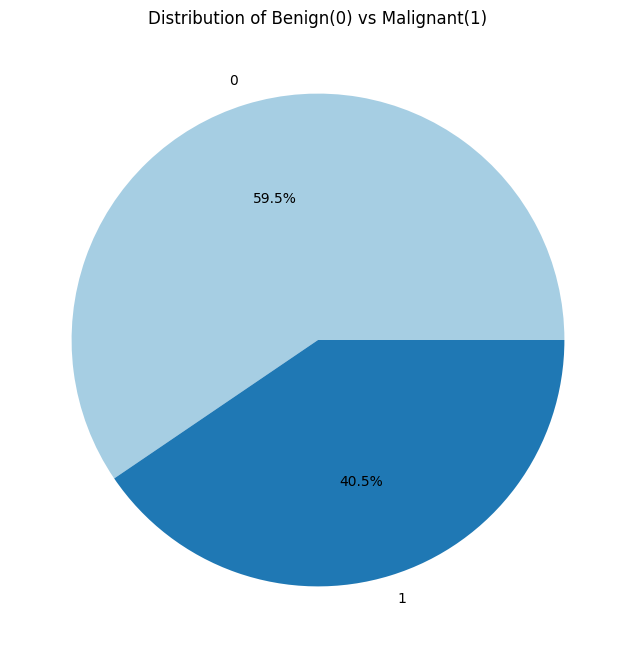

In [11]:
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=df["label"].unique(), autopct='%1.1f%%', colors=plt.cm.Paired.colors)
plt.title('Distribution of Benign(0) vs Malignant(1)')
plt.show()

Now let's look at a random sampling of 10 images.

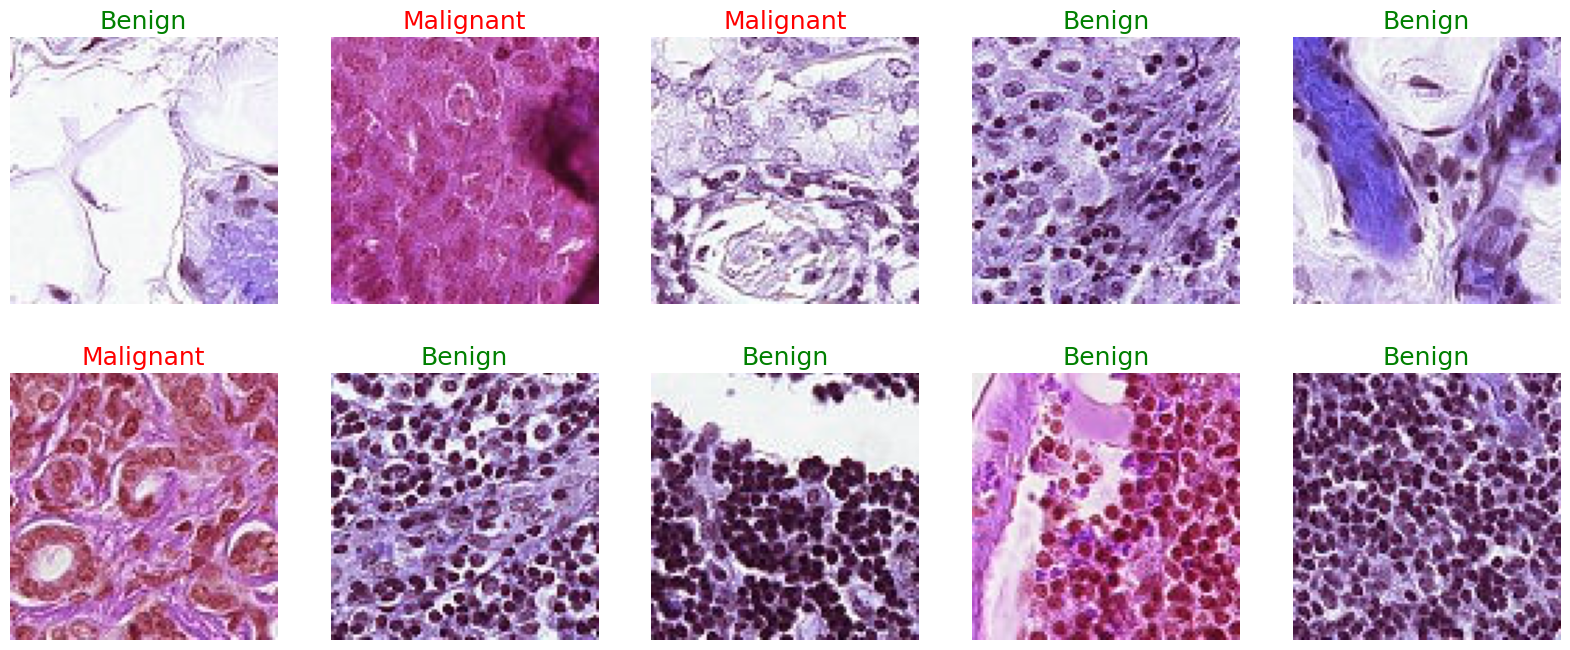

In [12]:
fig = plt.figure(figsize = (20,8))
index = 1
np.random.seed(3)
for i in np.random.randint(low = 0, high = df.shape[0], size = 10):
    file = train_path + df.iloc[i]['id']
    img = cv2.imread(file)
    ax = fig.add_subplot(2, 5, index)
    ax.imshow(img, cmap = 'gray')
    index = index + 1
    color = ['red' if df.iloc[i].label == '1' else 'green'][0]
    plt.axis('off')
    label = 'Malignant' if df.iloc[i].label == '1' else 'Benign'
    ax.set_title(label, fontsize = 18, color = color)

plt.show()

These 10 images show many different types of colors and shapes for the images which shows the image data is normalized. The dataset is also balanced with ~40% malignant labels and ~60% benign labels.
#### From our Exploratory Data Analysis, my plan of analysis is to start with a basic artchitecture for CNN then move on to a deeper model as I progress.

## Model Architecture

### Data Augmentation

In [20]:
IMAGE_SIZE = 96
BATCH_SIZE = 128

df_train, df_val = train_test_split(df, test_size=0.2, random_state=1)

# normalize the pixel values because they are 0-255
train_data_generator = ImageDataGenerator(rescale=1./255)
training_generator = train_data_generator.flow_from_dataframe(
    dataframe=df_train,
    directory=train_path,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary')

val_data_generator = ImageDataGenerator(rescale=1./255)
validation_generator = val_data_generator.flow_from_dataframe(
    dataframe=df_val,
    directory=train_path,
    x_col='id',
    y_col='label',
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary')

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [37]:
def plot_history(history, epochs):

    plt.plot(history.history['accuracy'], color='blue', label="train")
    plt.plot( history.history['val_accuracy'], color='red', label="validation")
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.show()

    plt.plot(history.history['loss'], color='blue', label="train")
    plt.plot(history.history['val_loss'], color='red', label="validation")
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.show()
    

First, start with a basic model with two convultion layers and a dropout layer with the default learning rate for Adam optimizer.

In [31]:
model_v1 = Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


model_v1.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model_v1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     1,982,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,001,985 (7.64 MB)

 Trainable params: 2,001,985 (7.64 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
EPOCHS = 10
history_v1 = model_v1.fit(
    training_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)

Epoch 1/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1342s 973ms/step - accuracy: 0.7437 - loss: 0.5302 - val_accuracy: 0.8070 - val_loss: 0.4321
Epoch 2/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 587s 427ms/step - accuracy: 0.8136 - loss: 0.4239 - val_accuracy: 0.8336 - val_loss: 0.3803
Epoch 3/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 620s 450ms/step - accuracy: 0.8319 - loss: 0.3905 - val_accuracy: 0.8409 - val_loss: 0.3711
Epoch 4/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 657s 478ms/step - accuracy: 0.8455 - loss: 0.3648 - val_accuracy: 0.8462 - val_loss: 0.3573
Epoch 5/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 723s 525ms/step - accuracy: 0.8553 - loss: 0.3417 - val_accuracy: 0.8450 - val_loss: 0.3654
Epoch 6/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 694s 504ms/step - accuracy: 0.8663 - loss: 0.3225 - val_accuracy: 0.8502 - val_loss: 0.3585
Epoch 7/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1588s 1s/step - accuracy: 0.8761 - loss: 0.3019 - val_accuracy: 0.8447 - val_loss: 0.3585
Epoch 8/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1119s 813ms/step - ac

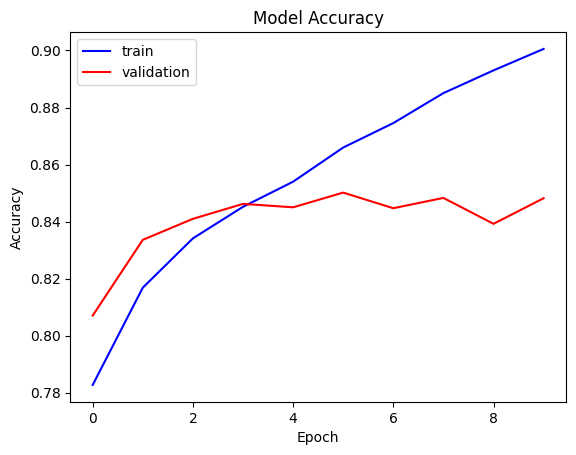

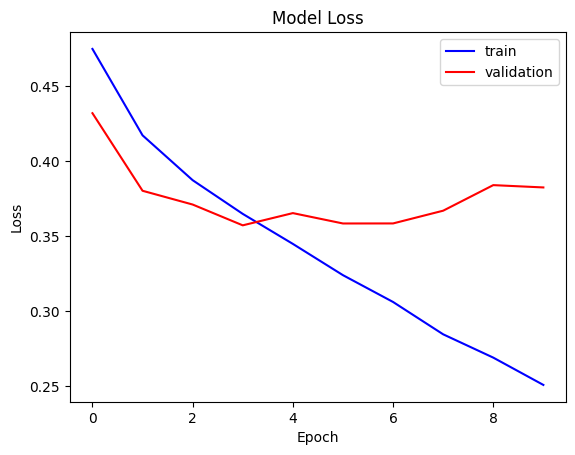

In [38]:
plot_history(history_v1, EPOCHS)

It looks like the validation loss was increasing after epoch 6, so I want to add a callback. Let's try another architecture by adding one more convolution layer. I also swapped dropout layer for batch normalization. The validation loss increased because of overfitting, so I will lower the learning rate by half.

In [52]:
model_v2 = Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

model_v2.summary()
model_v2.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
callback = EarlyStopping(patience=2,
                         verbose=1,
                         restore_best_weights=True)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_23 (Conv2D)              │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,732,417 (6.61 MB)

 Trainable params: 1,732,161 (6.61 MB)

 Non-trainable params: 256 (1.00 KB)

In [53]:
EPOCHS = 10
history_v2 = model_v2.fit(
    training_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[callback]
)

Epoch 1/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 329s 238ms/step - accuracy: 0.7966 - loss: 0.4490 - val_accuracy: 0.5632 - val_loss: 1.2548
Epoch 2/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 328s 238ms/step - accuracy: 0.8463 - loss: 0.3614 - val_accuracy: 0.7814 - val_loss: 0.4783
Epoch 3/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 328s 238ms/step - accuracy: 0.8672 - loss: 0.3137 - val_accuracy: 0.8808 - val_loss: 0.2898
Epoch 4/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 327s 238ms/step - accuracy: 0.8861 - loss: 0.2773 - val_accuracy: 0.8880 - val_loss: 0.2709
Epoch 5/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 328s 238ms/step - accuracy: 0.9001 - loss: 0.2481 - val_accuracy: 0.6667 - val_loss: 0.7935
Epoch 6/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 332s 241ms/step - accuracy: 0.9089 - loss: 0.2262 - val_accuracy: 0.8986 - val_loss: 0.2508
Epoch 7/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 343s 249ms/step - accuracy: 0.9165 - loss: 0.2100 - val_accuracy: 0.8912 - val_loss: 0.2765
Epoch 8/10
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 332s 241ms/step - ac

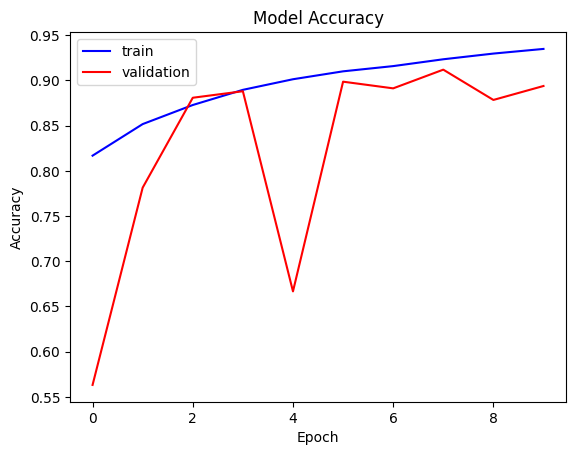

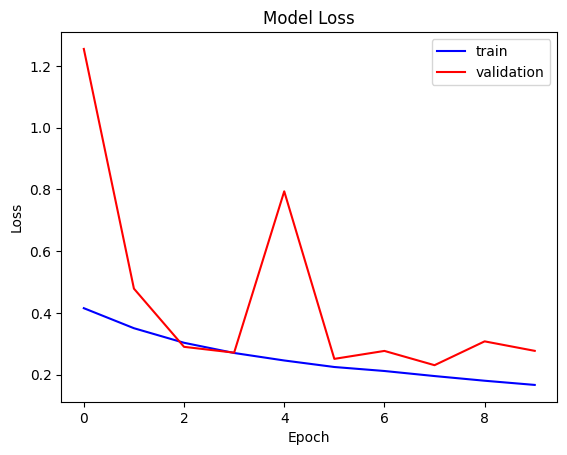

In [61]:
plot_history(history_v2, EPOCHS)

## Results and Analysis

Reducing the learning rate and adding a convolution layer reduced the validation loss by a lot and made the training and validation graphs have the same curve. I want to tune the hyperparameters even more to see if there is a way to decrease the validation loss even more. I will tune the optimization learning rate, number of convolution layers, and early stopping patience.

For the next model, I doubled each activation layer and kept the same learning rate as the previous model. I increased the number of epochs to 20 and increased the early stopping patience to 3.

In [56]:
model_v3 = Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

model_v3.summary()
model_v3.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

callback = EarlyStopping(patience=3,
                         verbose=1,
                         restore_best_weights=True)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 92, 92, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 42, 42, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 17, 17, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,344,801 (5.13 MB)

 Trainable params: 1,344,417 (5.13 MB)

 Non-trainable params: 384 (1.50 KB)

In [57]:
EPOCHS = 20
history_v3 = model_v3.fit(
    training_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[callback]
)

Epoch 1/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 334s 241ms/step - accuracy: 0.8017 - loss: 0.4456 - val_accuracy: 0.4538 - val_loss: 2.1688
Epoch 2/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 329s 239ms/step - accuracy: 0.8459 - loss: 0.3561 - val_accuracy: 0.5713 - val_loss: 1.5795
Epoch 3/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 328s 238ms/step - accuracy: 0.8749 - loss: 0.3000 - val_accuracy: 0.8798 - val_loss: 0.3284
Epoch 4/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 326s 237ms/step - accuracy: 0.8963 - loss: 0.2527 - val_accuracy: 0.6242 - val_loss: 1.6271
Epoch 5/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 329s 239ms/step - accuracy: 0.9112 - loss: 0.2235 - val_accuracy: 0.8857 - val_loss: 0.3096
Epoch 6/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 330s 240ms/step - accuracy: 0.9213 - loss: 0.2019 - val_accuracy: 0.9115 - val_loss: 0.2363
Epoch 7/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 328s 238ms/step - accuracy: 0.9282 - loss: 0.1855 - val_accuracy: 0.8728 - val_loss: 0.3027
Epoch 8/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 328s 238ms/step - ac

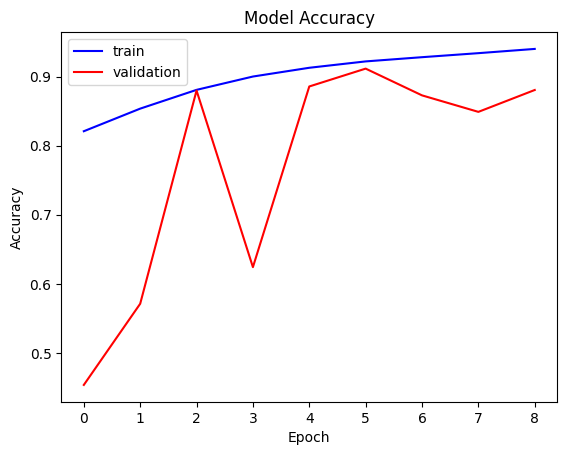

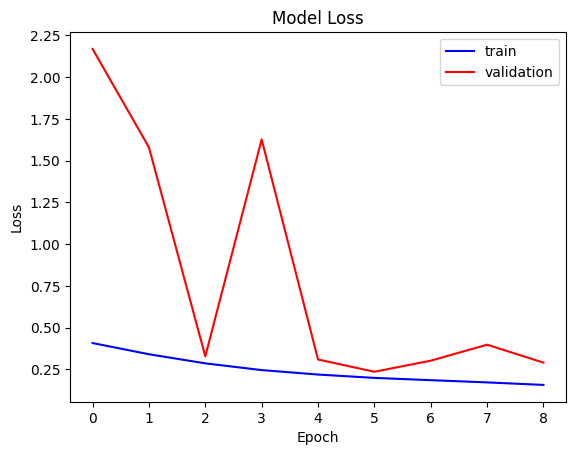

In [60]:
plot_history(history_v3, EPOCHS)

The validation accuracy and loss seem very volatile, so I increased the learning rate by a little bit and removed the extra dense layer in the classification section.

In [54]:
model_v4 = Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

model_v4.summary()
model_v4.compile(optimizer=Adam(learning_rate=0.0008), loss='binary_crossentropy', metrics=['accuracy'])

callback = EarlyStopping(patience=5,
                         verbose=1,
                         restore_best_weights=True)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)              │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 92, 92, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 42, 42, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 17, 17, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,336,353 (5.10 MB)

 Trainable params: 1,336,097 (5.10 MB)

 Non-trainable params: 256 (1.00 KB)

In [55]:
EPOCHS = 20
history_v4 = model_v4.fit(
    training_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[callback]
)

Epoch 1/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 341s 246ms/step - accuracy: 0.7969 - loss: 0.4459 - val_accuracy: 0.8561 - val_loss: 0.3605
Epoch 2/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 346s 251ms/step - accuracy: 0.8733 - loss: 0.3040 - val_accuracy: 0.7974 - val_loss: 0.5069
Epoch 3/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 326s 237ms/step - accuracy: 0.9001 - loss: 0.2492 - val_accuracy: 0.9092 - val_loss: 0.2281
Epoch 4/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 329s 239ms/step - accuracy: 0.9146 - loss: 0.2184 - val_accuracy: 0.9089 - val_loss: 0.2258
Epoch 5/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 328s 239ms/step - accuracy: 0.9233 - loss: 0.1978 - val_accuracy: 0.8991 - val_loss: 0.2544
Epoch 6/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 329s 239ms/step - accuracy: 0.9303 - loss: 0.1795 - val_accuracy: 0.9067 - val_loss: 0.2354
Epoch 7/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 330s 240ms/step - accuracy: 0.9377 - loss: 0.1629 - val_accuracy: 0.9254 - val_loss: 0.1918
Epoch 8/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 330s 240ms/step - ac

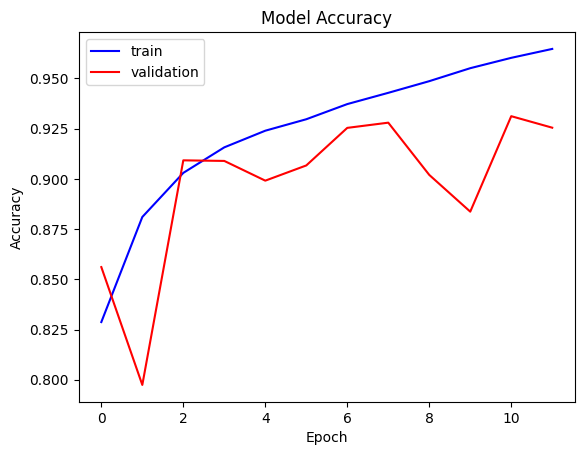

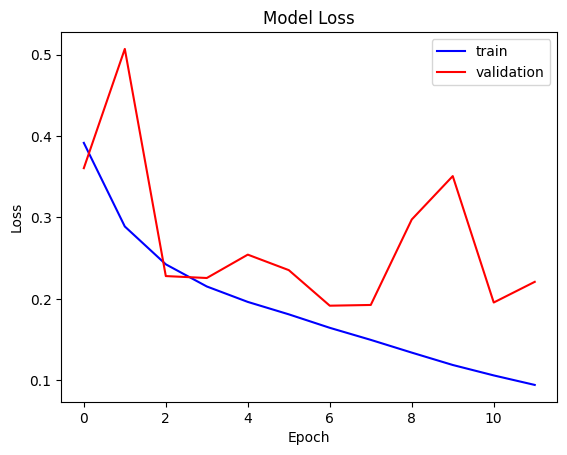

In [63]:
plot_history(history_v4, EPOCHS)

## Predict Test images with the best performing model and create the csv submission file

In [71]:
test_filenames = os.listdir(test_path)

test_df = pd.DataFrame({'filename': test_filenames})

test_data_generator = ImageDataGenerator(rescale=1./255)

test_generator = test_data_generator.flow_from_dataframe(
    dataframe=test_df,
    directory=test_path,
    x_col='filename',
    y_col=None,
    target_size=(96, 96),
    batch_size=32,
    class_mode=None,
    shuffle=False 
)

predictions = model_v4.predict(test_generator, verbose=1)


Found 57458 validated image filenames.


/home/fencer/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 279s 155ms/step


In [75]:
# Remove the '.tif' extension 
test_df['id'] = test_df['filename'].str[:-4]
test_df['label'] = predictions

# submission csv has just id and label
submission = test_df[['id', 'label']]
submission.head()

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,0.982354
1,0000ec92553fda4ce39889f9226ace43cae3364e,0.997182
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.928720
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0.106689
4,000270442cc15af719583a8172c87cd2bd9c7746,0.000618


In [76]:
submission.to_csv('kaggle_submission.csv', index=False)

## Conclusion

The deeper CNN model performed better with more convolution layers, but the validation loss was more volatile. Adding an extra dense layer in the classification part did not improve the validation accuracy, which was surprising. To improve the performance in the future, I would try transfer learning from the resnet model so I can tweak my architecture more without the time limitations. I would also want to try plotting out the different optimizers and their learning rates to optimize my hyperparameters more. Also, I want to play around with different batch sizes to see if that would help with the overfitting.